In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from nltk.corpus import stopwords
import re
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\icono\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Credit Status Dataset

## All features in a list with convenient type of data to use:
### Categorical
* <span style="color:red">ID</span>
* <span style="color:red">Customer_ID</span>
* Month (Can be converted to number or kept like this)
* <span style="color:red">Name</span>
* <span style="color:red">SSN</span>
* Occupation
* Type of Loan
* Credit_mix
* Payment behaviour
* Payment_of_min_amount

### Discrete
* Age
* Num_Bank_Accounts
* Interest Rate (Interest rate of loan)
* Num of Loan
* Delay_from_due_date
* Num_of_delayed_payment
* Num_Credit_Card	

### Continous
* Annual_Income
* Monthly_Inhand Salary
* Monthly_Balance
* Credit history age

We need a rule that can determine whether someone receives a credit or not, let's consider the following:
* Regular incomes.
* Enough payment capacity.
* Debt Ratio (Ratio de endeudamiento).
* Límite de capacidad de endeudamiento (Ingresos mensuales-Gastos Fijos) x0,40
* Number of bank accounts(More than 3 will be considered a risk)
* For discriminatory reasons, We won't consider ocuppation as a risk, we will focus more on other attributes.
* We will consider annual income divided by 12 instead of the monthly inhand salary, mainly because monthly inhand salary has a lot of missing values.It is relevant to consider annual income doesn't come with the same information that monthly inhand salary comes with.
* For the model, the Name won't matter to us as the number of loans already is enough to tell if someone should receive a credit or not.
* Interest rate can be relevant, however this does not determine whether someone gets a credit or not.
* The month 
#### Removing:
* ID
* Customer_ID
* Month
* Name
* Occupation
* Monthly Inhand Salary
* Interest Rate

We are missing the amount of loan that was asked.
The time needed for the payment to be concluded.

#### Data Exploration, Data Cleaning and Data Preprocessing

##### Numeric data cleaning

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mau-JS/OracleML/main/credit-status-dataset.csv')
test_csv = pd.read_csv('https://raw.githubusercontent.com/mau-JS/OracleML/main/TestCSV.csv')
#We create a temporary target before applying our rule to determine whether a credit is accepted or not.
df['Target'] = -1
test_csv['Target'] = -1
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,Good,22 Years and 9 Months,No,Low_spent_Small_value_payments,186.2667021,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,Good,22 Years and 10 Months,No,High_spent_Medium_value_payments,361.4440039,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,Good,NaN,No,Low_spent_Medium_value_payments,264.6754462,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,Good,23 Years and 0 Months,No,High_spent_Medium_value_payments,343.8268732,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,1,Credit-Builder Loan,3,1,Good,27 Years and 3 Months,No,High_spent_Large_value_payments,485.2984337,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,1929.906667,10,...,5,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33,25,_,NaN,Yes,Low_spent_Small_value_payments,275.5395695,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,NaN,4,...,2_,"Auto Loan, and Student Loan",20,NaN,Good,31 Years and 11 Months,NM,Low_spent_Small_value_payments,409.3945617,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,2,"Auto Loan, and Student Loan",23,5,Good,32 Years and 0 Months,No,Low_spent_Large_value_payments,349.7263321,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,NaN,4,...,2_,"Auto Loan, and Student Loan",21,6_,Good,32 Years and 1 Months,No,High_spent_Small_value_payments,463.238981,-1


In [3]:
#For consistency and relevance, we convert years and months to continous values. Our years will be kept as discrete values and months as decimals.
df['Credit_History_Age'] = df['Credit_History_Age'].replace('NA', np.nan)

def convert_to_years(s):
    if pd.isnull(s):
        return np.nan
    years, months = 0, 0
    if isinstance(s, str):
        parts = s.split('and')
        if 'Year' in parts[0]:
            years = int(parts[0].split(' Year')[0])
        if len(parts) > 1 and 'Month' in parts[1]:
            months = int(parts[1].split(' Month')[0])
    return years + months / 12.0

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_to_years)


In [4]:
# Define a function to fill missing values with mode
def fill_with_mode(s):
    mode = s.mode().iloc[0] if not s.mode().empty else np.nan
    return s.fillna(mode)

In [5]:
#This will help us notice what columns are numeric or not. This can tell us if we have to convert the data to other format or apply data cleaning.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,42502.0,4182.004291,3174.109304,303.645417,1625.188333,3086.305,5934.189094,15204.63333
Num_Bank_Accounts,50000.0,16.838260,116.396848,-1.000000,3.000000,6.000,7.000000,1798.00000
Num_Credit_Card,50000.0,22.921480,129.314804,0.000000,4.000000,5.000,7.000000,1499.00000
Interest_Rate,50000.0,68.772640,451.602363,1.000000,8.000000,13.000,20.000000,5799.00000
Delay_from_due_date,50000.0,21.052640,14.860397,-5.000000,10.000000,18.000,28.000000,67.00000
Credit_History_Age,45530.0,18.937598,8.296197,0.833333,12.583333,18.750,25.583333,34.00000
Target,50000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000,-1.000000,-1.00000


Removing unknown symbols from Age and converting to numeric data

In [6]:
# Replacing non-numeric characters with an empty string
df['Age'] = df['Age'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Age'] = pd.to_numeric(df['Age'])

In [7]:
#Now age is with the proper format and with non numeric symbols removed.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,678.133254,14.000000,25.000000,34.000,43.000000,8688.00000
Monthly_Inhand_Salary,42502.0,4182.004291,3174.109304,303.645417,1625.188333,3086.305,5934.189094,15204.63333
Num_Bank_Accounts,50000.0,16.838260,116.396848,-1.000000,3.000000,6.000,7.000000,1798.00000
Num_Credit_Card,50000.0,22.921480,129.314804,0.000000,4.000000,5.000,7.000000,1499.00000
Interest_Rate,50000.0,68.772640,451.602363,1.000000,8.000000,13.000,20.000000,5799.00000
Delay_from_due_date,50000.0,21.052640,14.860397,-5.000000,10.000000,18.000,28.000000,67.00000
Credit_History_Age,45530.0,18.937598,8.296197,0.833333,12.583333,18.750,25.583333,34.00000
Target,50000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000,-1.000000,-1.00000


We do not need to filter Num_Bank_Accounts, Num_Credit_Card, Interest Rate.

We check if values that should be numerical, are really numerical. Then clean our data for Annual_Income.

In [8]:
print(df['Annual_Income'].dtypes)

# Replace non-numeric characters with an empty string
df['Annual_Income'] = df['Annual_Income'].str.replace(r'[^\d.]', '', regex=True)

# Convert the 'Annual_Income' column to numeric type, treating 'N/A' as NaN
df['Annual_Income'] = pd.to_numeric(df['Annual_Income'], errors='coerce')
#We print again to verify all values are numbers.
print(df['Annual_Income'].dtypes)

object
float64


We remove Monthly_Inhand_Salary cause it has a lot of missing data and we already have Annual Income.

In [9]:
df.drop(['Monthly_Inhand_Salary'], axis=1, inplace=True)
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Credit_Mix', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Payment_Behaviour', 'Monthly_Balance',
       'Target'],
      dtype='object')

We clean Num_of_Loan

In [10]:
# Convert the 'Num_of_Loan' column to string type
df['Num_of_Loan'] = df['Num_of_Loan'].astype(str)

# Remove non-numeric characters except the minus sign
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace(r'[^\d-]', '', regex=True)

# Convert the 'Num_of_Loan' column to numeric type
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'])

# Replace negative values with NaN
df.loc[df['Num_of_Loan'] < 0, 'Num_of_Loan'] = np.nan

# Convert the column to string
df['Num_of_Loan'] = df['Num_of_Loan'].astype(str)

# Remove non-numeric characters
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace(r'\D', '', regex=True)

# Convert the column to numeric
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'], errors='coerce')

We clean Delay_from_due_date

In [11]:
# Convert the 'Num_of_Loan' column to string type
df['Delay_from_due_date'] = df['Delay_from_due_date'].astype(str)

# Remove non-numeric characters except the minus sign
df['Delay_from_due_date'] = df['Delay_from_due_date'].str.replace(r'[^\d-]', '', regex=True)

# Convert the 'Num_of_Loan' column to numeric type
df['Delay_from_due_date'] = pd.to_numeric(df['Delay_from_due_date'])

# Replace negative values with NaN
df.loc[df['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = np.nan

We clean Num_of_Delayed_Payment

In [12]:
# Replacing non-numeric characters with an empty string
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'])

df['Num_of_Delayed_Payment'] = df .groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(fill_with_mode)
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.2667021,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.4440039,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",NaN,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.6754462,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.8268732,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,10.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.2984337,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,50.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.5395695,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,NM,Low_spent_Small_value_payments,409.3945617,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.7263321,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


We clean Monthly_Balance

In [13]:
print(df['Monthly_Balance'].dtypes)

# Replace non-numeric characters with an empty string
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace(r'[^\d.]', '', regex=True)

# Convert the 'Annual_Income' column to numeric type, treating 'N/A' as NaN
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')
#We print again to verify all values are numbers.
print(df['Monthly_Balance'].dtypes)

object
float64


Mode imputation for Annual_Income

In [14]:
# Apply the function to the 'Annual_Income' column grouped by 'Customer_ID'
df['Annual_Income'] = df .groupby('Customer_ID')['Annual_Income'].transform(fill_with_mode)
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",NaN,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,10.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,50.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Removing Annual_Income outliers

In [15]:
Q1 = df['Annual_Income'].quantile(0.25)
Q3 = df['Annual_Income'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Annual_Income'] < (Q1 - 1.5 * IQR)) | (df['Annual_Income'] > (Q3 + 1.5 * IQR)))]

25/10/2023 Code

Removing Num_Bank_Accounts outliers.

In [16]:
# Calculate the IQR of the column
Q1 = df['Num_Bank_Accounts'].quantile(0.25)
Q3 = df['Num_Bank_Accounts'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Num_Bank_Accounts'] < (Q1 - outlier_step)) | (df['Num_Bank_Accounts'] > (Q3 + outlier_step)))]
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Credit_Mix', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Payment_Behaviour', 'Monthly_Balance',
       'Target'],
      dtype='object')

Removing Bank Account outliers

In [17]:
# Calculate the IQR of the column
Q1 = df['Num_Credit_Card'].quantile(0.25)
Q3 = df['Num_Credit_Card'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Num_Credit_Card'] < (Q1 - outlier_step)) | (df['Num_Credit_Card'] > (Q3 + outlier_step)))]
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",NaN,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,10.0,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,50.0,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20.0,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Removing Interest Rate outliers

In [18]:
# Calculate the IQR of the column
Q1 = df['Interest_Rate'].quantile(0.25)
Q3 = df['Interest_Rate'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Interest_Rate'] < (Q1 - outlier_step)) | (df['Interest_Rate'] > (Q3 + outlier_step)))]

Mode Imputation for Num of Loan

In [19]:
# Define a function to fill missing values with mode
def fill_with_mode(s):
    mode = s.mode().iloc[0] if not s.mode().empty else np.nan
    return s.fillna(mode)

# Replace negative values with NaN
df.loc[df['Num_of_Loan'] < 0, 'Num_of_Loan'] = np.nan

# Create a copy of the DataFrame
df_copy = df.copy()

# Fill NaN values with the mode
df_copy['Num_of_Loan'] = df_copy.groupby('Customer_ID')['Num_of_Loan'].transform(fill_with_mode)

# Replace the original DataFrame with the copy
df = df_copy

# Drop rows with NaN in 'Num_of_Loan'
df = df.dropna(subset=['Num_of_Loan'])

# Create a copy of DataFrame and convert 'Num_of_Loan' to integer in the copy
df = df.copy()
df['Num_of_Loan'] = df['Num_of_Loan'].astype(int)


Removing Num of Loan Outliers

In [20]:
# Calculate the IQR of the column
Q1 = df['Num_of_Loan'].quantile(0.25)
Q3 = df['Num_of_Loan'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Num_of_Loan'] < (Q1 - outlier_step)) | (df['Num_of_Loan'] > (Q3 + outlier_step)))]

Mode Imputation for Delay from Due Date

In [21]:
df = df.copy()
df['Delay_from_due_date'] = df.groupby('Customer_ID')['Delay_from_due_date'].transform(fill_with_mode)
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,10,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,50,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Removing Delay from Due Date outliers.

In [22]:
# Calculate the IQR of the column
Q1 = df['Delay_from_due_date'].quantile(0.25)
Q3 = df['Delay_from_due_date'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Delay_from_due_date'] < (Q1 - outlier_step)) | (df['Delay_from_due_date'] > (Q3 + outlier_step)))]


Removing Num of Delayed Payment outliers.

In [23]:
# Calculate the IQR of the column
Q1 = df['Num_of_Delayed_Payment'].quantile(0.25)
Q3 = df['Num_of_Delayed_Payment'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Num_of_Delayed_Payment'] < (Q1 - outlier_step)) | (df['Num_of_Delayed_Payment'] > (Q3 + outlier_step)))]
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,NaN,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,10,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,50,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,NaN,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Imputation for credit history age where it increases per month. It makes sense to make data imputation for each value missing based on the others.

In [24]:
# Interpolate the 'Credit_History_Age' column
df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].apply(lambda group: group.interpolate()).reset_index(level=0, drop=True)
# Fill NaN for customers with one row with the median of all customers
df['Credit_History_Age'] = df['Credit_History_Age'].fillna(df['Credit_History_Age'].median())
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.266702,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444004,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,22.916667,No,Low_spent_Medium_value_payments,264.675446,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,3,4,...,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.826873,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,2,4,...,10,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298434,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,10,8,...,50,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,_,6.500000,Yes,Low_spent_Small_value_payments,275.539570,-1
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,NM,Low_spent_Small_value_payments,409.394562,-1
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726332,-1
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,4,6,...,20,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.238981,-1


Reducing the amount of decimals for **Monthly_Balance**

In [25]:
# Round 'Monthly_Balance' to 3 decimal places
df['Monthly_Balance'] = df['Monthly_Balance'].round(3)

Making mode imputation per Customer ID

In [26]:
df['Monthly_Balance'] = df.groupby('Customer_ID')['Monthly_Balance'].transform(fill_with_mode)

Removing outliers from **Monthly_Balance**

In [27]:
# Calculate the IQR of the column
Q1 = df['Monthly_Balance'].quantile(0.25)
Q3 = df['Monthly_Balance'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier step
outlier_step = 1.5 * IQR

# Remove outliers from the DataFrame
df = df[~((df['Monthly_Balance'] < (Q1 - outlier_step)) | (df['Monthly_Balance'] > (Q3 + outlier_step)))]

Correlation Matrix

In [28]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Print correlation matrix
print(corr_matrix)

                             Age  Annual_Income  Num_Bank_Accounts  \
Age                     1.000000       0.000923          -0.001199   
Annual_Income           0.000923       1.000000          -0.196023   
Num_Bank_Accounts      -0.001199      -0.196023           1.000000   
Num_Credit_Card        -0.010423      -0.158504           0.433030   
Interest_Rate           0.003796      -0.223443           0.565556   
Num_of_Loan             0.003554      -0.151875           0.456443   
Delay_from_due_date     0.005132      -0.173203           0.543449   
Num_of_Delayed_Payment  0.004174      -0.183692           0.581591   
Credit_History_Age      0.005163       0.189851          -0.464443   
Monthly_Balance        -0.001914       0.500250          -0.245225   
Target                       NaN            NaN                NaN   

                        Num_Credit_Card  Interest_Rate  Num_of_Loan  \
Age                           -0.010423       0.003796     0.003554   
Annual_Income    

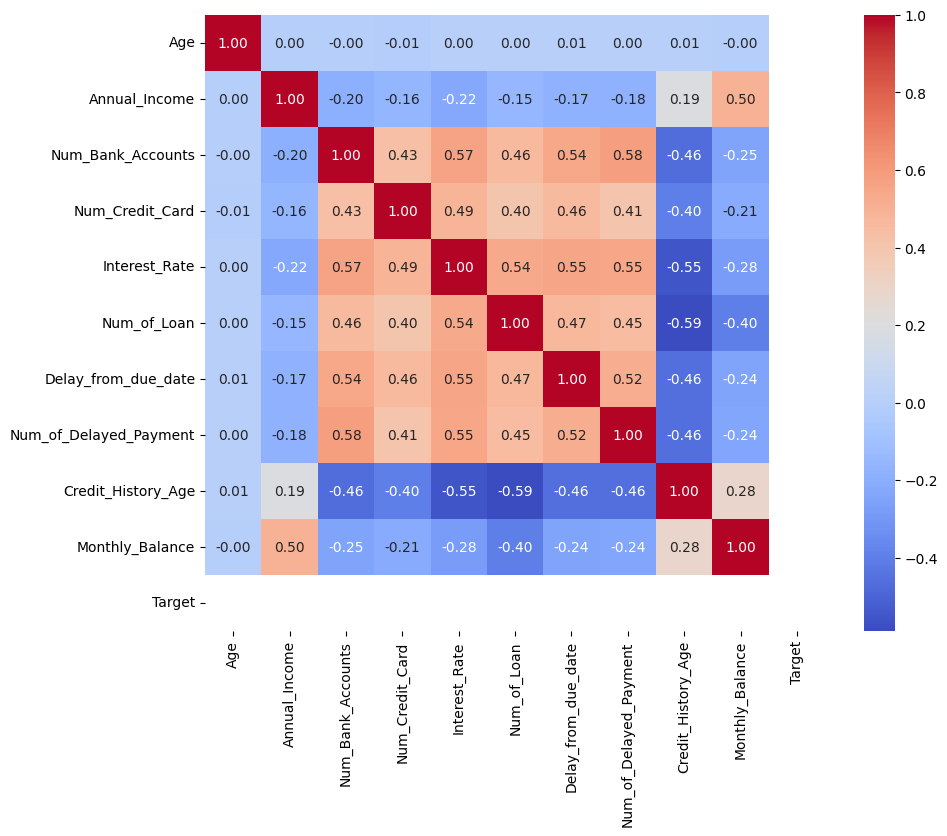

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

Now working with categorical data (ID,Customer_ID,Month, Name, SSN, Occupation, Type_of_Loan, Credit_Mix, Payment_of_Min_Amount, Payment_Behaviour)

Cleaning Data

In [30]:
#Removing unnecesary columns
df = df.drop(['ID','SSN','Name','ID','Occupation'], axis = 1)
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
print(non_numeric_columns)

Index(['Customer_ID', 'Month', 'Num_of_Loan', 'Type_of_Loan', 'Credit_Mix',
       'Payment_of_Min_Amount', 'Payment_Behaviour'],
      dtype='object')


Cleaning Credit_Mix column and imputating values

In [31]:
# Replace underscores with NaN
df['Credit_Mix'].replace('_', np.nan, inplace=True)

# Fill NaN for customers with one row with the mode of all customers
df['Credit_Mix'] = df.groupby('Customer_ID')['Credit_Mix'].transform(fill_with_mode)

# Remove rows where all values for a specific 'Customer_ID' in the 'Credit_Mix' column are NaN
df = df[~df.groupby('Customer_ID')['Credit_Mix'].transform(lambda x: x.isna().all())]
df

,Customer_ID,Month,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,CUS_0xd40,September,23,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.267,-1
1,CUS_0xd40,October,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444,-1
2,CUS_0xd40,November,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,22.916667,No,Low_spent_Medium_value_payments,264.675,-1
3,CUS_0xd40,December,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.827,-1
4,CUS_0x21b1,September,28,34847.84,2,4,6,10,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,CUS_0x8600,December,4975,20002.88,10,8,29,50,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,Bad,6.500000,Yes,Low_spent_Small_value_payments,275.540,-1
49996,CUS_0x942c,September,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,NM,Low_spent_Small_value_payments,409.395,-1
49997,CUS_0x942c,October,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726,-1
49998,CUS_0x942c,November,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.239,-1


Cleaning and Imputation of Payment_Behaviour

In [32]:
# Define the specified values
specified_values = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_High_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_High_value_payments'
]

# Fill NaN with mode for rows where 'Payment_Behaviour' is not one of the specified values
mask = ~df['Payment_Behaviour'].isin(specified_values)
df.loc[mask, 'Payment_Behaviour'] = df.loc[mask].groupby('Customer_ID')['Payment_Behaviour'].transform(fill_with_mode)

Cleaning and data imputation of Payment Behaviour

In [33]:
df['Payment_of_Min_Amount'].replace('NM', np.nan, inplace=True)
df['Payment_of_Min_Amount'] = df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(fill_with_mode)
df

,Customer_ID,Month,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,CUS_0xd40,September,23,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.267,-1
1,CUS_0xd40,October,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444,-1
2,CUS_0xd40,November,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,22.916667,No,Low_spent_Medium_value_payments,264.675,-1
3,CUS_0xd40,December,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.827,-1
4,CUS_0x21b1,September,28,34847.84,2,4,6,10,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,CUS_0x8600,December,4975,20002.88,10,8,29,50,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,Bad,6.500000,Yes,Low_spent_Small_value_payments,275.540,-1
49996,CUS_0x942c,September,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,No,Low_spent_Small_value_payments,409.395,-1
49997,CUS_0x942c,October,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726,-1
49998,CUS_0x942c,November,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.239,-1


In [34]:
print(non_numeric_columns)

Index(['Customer_ID', 'Month', 'Num_of_Loan', 'Type_of_Loan', 'Credit_Mix',
       'Payment_of_Min_Amount', 'Payment_Behaviour'],
      dtype='object')


Data Cleaning of Type of Loan and data imputation, if all rows are NaN it substitutes with "None"

In [35]:
def fill_with_mode(s):
    # If all values are NaN, return 'None'
    if s.isna().all():
        return 'None'
    else:
        # Calculate the mode and return it
        mode = s.mode().iloc[0] if not s.mode().empty else np.nan
        return s.fillna(mode)

# Apply the modified function
df['Type_of_Loan'] = df.groupby('Customer_ID')['Type_of_Loan'].transform(fill_with_mode)
df

,Customer_ID,Month,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,CUS_0xd40,September,23,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,Good,22.750000,No,Low_spent_Small_value_payments,186.267,-1
1,CUS_0xd40,October,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,9.0,Good,22.833333,No,High_spent_Medium_value_payments,361.444,-1
2,CUS_0xd40,November,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,4.0,Good,22.916667,No,Low_spent_Medium_value_payments,264.675,-1
3,CUS_0xd40,December,24,19114.12,3,4,3,40,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4.0,5.0,Good,23.000000,No,High_spent_Medium_value_payments,343.827,-1
4,CUS_0x21b1,September,28,34847.84,2,4,6,10,Credit-Builder Loan,3.0,1.0,Good,27.250000,No,High_spent_Large_value_payments,485.298,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,CUS_0x8600,December,4975,20002.88,10,8,29,50,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33.0,25.0,Bad,6.500000,Yes,Low_spent_Small_value_payments,275.540,-1
49996,CUS_0x942c,September,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",20.0,5.0,Good,31.916667,No,Low_spent_Small_value_payments,409.395,-1
49997,CUS_0x942c,October,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",23.0,5.0,Good,32.000000,No,Low_spent_Large_value_payments,349.726,-1
49998,CUS_0x942c,November,25,39628.99,4,6,7,20,"Auto Loan, and Student Loan",21.0,6.0,Good,32.083333,No,High_spent_Small_value_payments,463.239,-1


Customer_ID was only used for data imputation per customer, now we can drop it.

In [36]:
def define_target(df):
    # Define your rule here
    df['Target'] = df.apply(lambda row: 1 if (row['Credit_History_Age'] > 23 and row['Annual_Income'] > 15000 and row['Num_Bank_Accounts'] < 7 and row['Num_of_Loan'] < 20) else 0, axis=1)
    return df

test_csv = define_target(test_csv)
num_accepted_test = test_csv['Target'].sum()
df = define_target(df)
num_accepted = df['Target'].sum()
print(f"The number of accepted credits is {num_accepted}")
print(f"The number of accepted credits is {num_accepted_test}")

The number of accepted credits is 3535
The number of accepted credits is 3914


Obtaining Chi-Square Test

In [37]:
from scipy.stats import chi2_contingency

# List of non-numeric columns
non_numeric_columns = ['Month', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

# Apply Chi-Square test for each pair of non-numeric columns
for i in range(len(non_numeric_columns)):
    for j in range(i+1, len(non_numeric_columns)):
        # Create a contingency table
        contingency_table = pd.crosstab(df[non_numeric_columns[i]], df[non_numeric_columns[j]])
        
        # Perform the Chi-Square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Print the results
        print(f"Chi-Square test between {non_numeric_columns[i]} and {non_numeric_columns[j]}:")
        print(f"Chi2 value: {chi2}, p-value: {p}")


Chi-Square test between Month and Type_of_Loan:
Chi2 value: 2219.36299591173, p-value: 1.0
Chi-Square test between Month and Credit_Mix:
Chi2 value: 0.3538167132491096, p-value: 0.9991914099235137
Chi-Square test between Month and Payment_of_Min_Amount:
Chi2 value: 0.10709512197668261, p-value: 0.9909725964430901
Chi-Square test between Month and Payment_Behaviour:
Chi2 value: 16.65977514962397, p-value: 0.5466015748673085
Chi-Square test between Type_of_Loan and Credit_Mix:
Chi2 value: 51358.62706840812, p-value: 0.0
Chi-Square test between Type_of_Loan and Payment_of_Min_Amount:
Chi2 value: 21479.29619870935, p-value: 0.0
Chi-Square test between Type_of_Loan and Payment_Behaviour:
Chi2 value: 37407.23827489748, p-value: 9.583648038818292e-21
Chi-Square test between Credit_Mix and Payment_of_Min_Amount:
Chi2 value: 26080.865749638644, p-value: 0.0
Chi-Square test between Credit_Mix and Payment_Behaviour:
Chi2 value: 187.278869806278, p-value: 1.3632787851473628e-33
Chi-Square test bet

Independent
* Month and Type_of_Loan 
* Month and Credit_Mix 
* Month and Payment_of_Min_Amount
* Month and Payment_Behaviour

Dependent
* Type_of_Loan and Credit_Mix
* Type_of_Loan and Payment_of_Min_Amount
* Type_of_Loan and Payment_Behaviour
* Credit_Mix and Payment_of_Min_Amount
* Credit_Mix and Payment_Behaviour
* Payment_of_Min_Amount and Payment_Behaviour

Given these values and taking a p-value of 0.05 as threshold we will remove the following columns for our machine learning algorithms to reduce complexity. We can consider them again to check if our results can improve
* Type of Loan
* Payment_of_Min_Amount
* Payment_Behaviour


In [38]:
df = df.drop(['Type_of_Loan','Payment_of_Min_Amount','Payment_Behaviour','Customer_ID'], axis = 1)
df

,Month,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Monthly_Balance,Target
0,September,23,19114.12,3,4,3,40,3.0,7.0,Good,22.750000,186.267,0
1,October,24,19114.12,3,4,3,40,3.0,9.0,Good,22.833333,361.444,0
2,November,24,19114.12,3,4,3,40,3.0,4.0,Good,22.916667,264.675,0
3,December,24,19114.12,3,4,3,40,4.0,5.0,Good,23.000000,343.827,0
4,September,28,34847.84,2,4,6,10,3.0,1.0,Good,27.250000,485.298,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,December,4975,20002.88,10,8,29,50,33.0,25.0,Bad,6.500000,275.540,0
49996,September,25,39628.99,4,6,7,20,20.0,5.0,Good,31.916667,409.395,0
49997,October,25,39628.99,4,6,7,20,23.0,5.0,Good,32.000000,349.726,0
49998,November,25,39628.99,4,6,7,20,21.0,6.0,Good,32.083333,463.239,0


In [39]:
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
print(df.columns)

Index(['Month', 'Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Credit_Mix', 'Credit_History_Age',
       'Monthly_Balance', 'Target'],
      dtype='object')


Machine Learning Model

In [40]:
from sklearn.model_selection import train_test_split

# Split your data into training and test sets
X = df.drop('Target', axis = 1)
y = df['Target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Month,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Monthly_Balance
7872,September,44,33714.380,10,10,15,90,30.0,17.0,Bad,2.333333,181.876
42364,September,28,14293.345,8,5,10,50,16.0,12.0,Standard,7.083333,221.942
23764,September,29,38305.280,7,5,15,50,16.0,23.0,Bad,6.250000,261.896
30442,November,15,74829.560,7,9,25,60,49.0,18.0,Bad,17.500000,474.236
31054,November,39,108457.740,6,7,13,40,5.0,18.0,Standard,15.750000,221.263
...,...,...,...,...,...,...,...,...,...,...,...,...
7877,October,20,17497.830,3,7,19,40,25.0,15.0,Standard,10.083333,204.552
14080,September,19,33579.270,6,5,20,30,20.0,14.0,Standard,21.416667,380.002
47602,November,3545,67321.160,3,4,5,30,30.0,9.0,Standard,13.666667,297.569
1092,September,40,63101.140,3,4,3,40,2.0,9.0,Good,17.083333,476.017


Month encoding

In [41]:
from sklearn.preprocessing import OrdinalEncoder

# Create an instance of OrdinalEncoder
encoder = OrdinalEncoder(categories=[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']])

# Fit the encoder on the training data
encoder.fit(X_train[['Month']])

# Transform the 'Month' column in the training and test sets
X_train['Month'] = encoder.transform(X_train[['Month']])
X_val['Month'] = encoder.transform(X_val[['Month']])

Credit Mix encoding

In [42]:
from sklearn.preprocessing import OrdinalEncoder

# Creating an instance of OrdinalEncoder
encoder_credit_mix = OrdinalEncoder(categories=[['Bad', 'Standard', 'Good']])

# Fitting the encoder on the training data
encoder_credit_mix.fit(X_train[['Credit_Mix']])

# Transforming the 'Credit_Mix' column in the training and test sets
X_train['Credit_Mix'] = encoder_credit_mix.transform(X_train[['Credit_Mix']])
X_val['Credit_Mix'] = encoder_credit_mix.transform(X_val[['Credit_Mix']])

In [43]:
X_train['Delay_from_due_date'] = X_train['Delay_from_due_date'].astype('Int64')
X_train['Num_of_Delayed_Payment'] = X_train['Num_of_Delayed_Payment'].astype('Int64')
X_train['Credit_Mix'] = X_train['Credit_Mix'].astype('Int64')
X_train['Month'] = X_train['Month'].astype('Int64')
X_train

,Month,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Monthly_Balance
7872,8,44,33714.380,10,10,15,90,30,17,0,2.333333,181.876
42364,8,28,14293.345,8,5,10,50,16,12,1,7.083333,221.942
23764,8,29,38305.280,7,5,15,50,16,23,0,6.250000,261.896
30442,10,15,74829.560,7,9,25,60,49,18,0,17.500000,474.236
31054,10,39,108457.740,6,7,13,40,5,18,1,15.750000,221.263
...,...,...,...,...,...,...,...,...,...,...,...,...
7877,9,20,17497.830,3,7,19,40,25,15,1,10.083333,204.552
14080,8,19,33579.270,6,5,20,30,20,14,1,21.416667,380.002
47602,10,3545,67321.160,3,4,5,30,30,9,1,13.666667,297.569
1092,8,40,63101.140,3,4,3,40,2,9,2,17.083333,476.017


In [44]:
y_test = test_csv['Target']
X_test = test_csv.drop('Target', axis=1)

Machine Learning Algorithms

In [45]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Dropping the few NaN values that remain after data cleaning
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]

X_val.dropna(inplace=True)
y_val = y_val[X_val.index]

# Defining logistic model
logistic_regression = LogisticRegression(max_iter=1000)


# Creating a scaler
scaler = StandardScaler()

# Fitting and transforming the train data with the scaler
X_train_scaled = scaler.fit_transform(X_train)

# Transforming the validation data with the scaler
X_val_scaled = scaler.transform(X_val)

# Transforming the test data with the scaler
X_test_scaled = scaler.transform(X_test)


# Training your models
logistic_regression.fit(X_train_scaled, y_train)


# Making predictions on your validation data
lr_predictions = logistic_regression.predict(X_val_scaled)


# Evaluate your models
print("Logistic Regression performance:")
print(classification_report(y_val, lr_predictions))

Logistic Regression performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7320
           1       0.82      0.72      0.76       700

    accuracy                           0.96      8020
   macro avg       0.90      0.85      0.87      8020
weighted avg       0.96      0.96      0.96      8020



In [46]:
# Making predictions on your test data
lr_predictions_test = logistic_regression.predict(X_test_scaled)


# Evaluate your models
print("Logistic Regression performance on test:")
print(classification_report(y_test, lr_predictions_test))

Logistic Regression performance on test:
              precision    recall  f1-score   support

           0       0.98      0.02      0.05     16086
           1       0.20      1.00      0.33      3914

    accuracy                           0.22     20000
   macro avg       0.59      0.51      0.19     20000
weighted avg       0.83      0.22      0.10     20000



In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Performing cross-validation
lr_scores = cross_val_score(logistic_regression, X_train_scaled, y_train, cv=5)


# Printing cross-validation scores
print("Logistic Regression Cross-Validation Scores:", lr_scores)


# Print the mean cross-validation score
print("Mean Cross-Validation Score for Logistic Regression:", lr_scores.mean())

Logistic Regression Cross-Validation Scores: [0.95572876 0.95572186 0.95634549 0.95509822 0.95852822]
Mean Cross-Validation Score for Logistic Regression: 0.9562845111081785


In [48]:
from sklearn.metrics import confusion_matrix
lr_cm = confusion_matrix(y_val, lr_predictions)
print("Confusion Matrix for Logistic Regression:")
print(lr_cm)

Confusion Matrix for Logistic Regression:
[[7208  112]
 [ 198  502]]


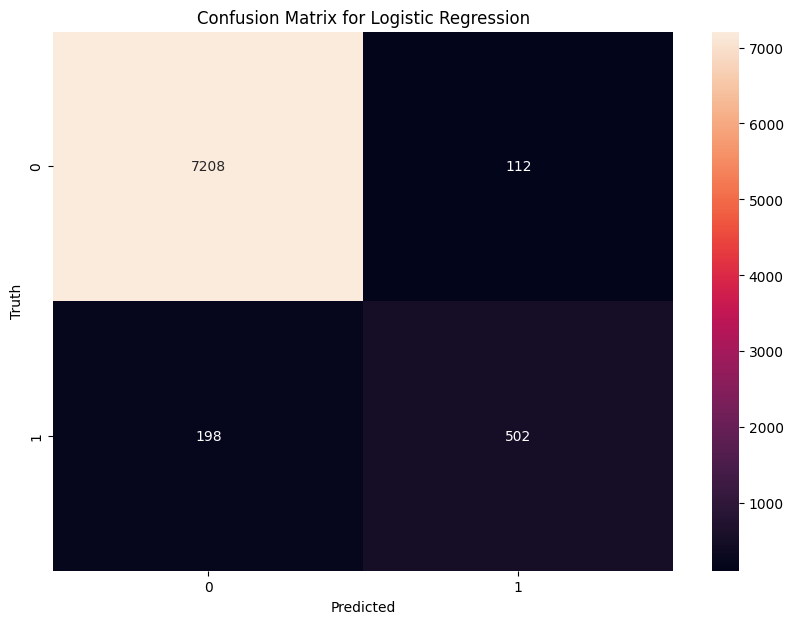

In [49]:
# Plotting confusion matrix for Logistic Regression
plt.figure(figsize=(10,7))
sns.heatmap(lr_cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

---

##### K neighbors

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Defining model
knn = KNeighborsClassifier(n_neighbors=3)

# Performing cross-validation
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)

# Printing cross-validation scores
print("K-Nearest Neighbors Cross-Validation Scores:", knn_scores)

# Printing the mean cross-validation score
print("Mean Cross-Validation Score for K-Nearest Neighbors:", knn_scores.mean())

K-Nearest Neighbors Cross-Validation Scores: [0.96227592 0.96180231 0.96554412 0.96195822 0.96117867]
Mean Cross-Validation Score for K-Nearest Neighbors: 0.962551846712946


In [51]:
knn.fit(X_train_scaled, y_train)

# Make predictions on your test data
knn_predictions = knn.predict(X_val_scaled)


# Evaluate your models
print("K neighbors performance:")
print(classification_report(y_val, knn_predictions))

K neighbors performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7320
           1       0.84      0.75      0.79       700

    accuracy                           0.96      8020
   macro avg       0.91      0.87      0.88      8020
weighted avg       0.96      0.96      0.96      8020



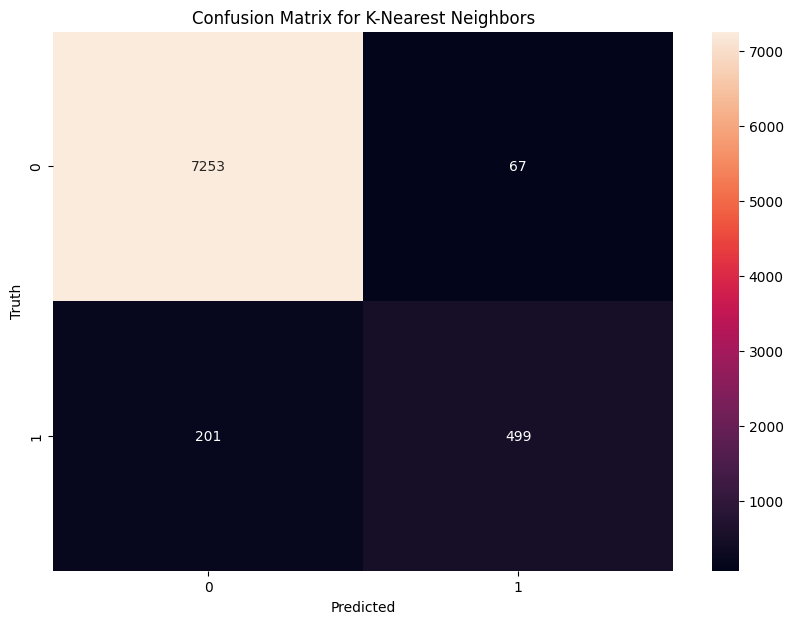

In [58]:
from sklearn.metrics import confusion_matrix
knn_cm = confusion_matrix(y_val, knn_predictions)
# Plotting confusion matrix for K-Nearest Neighbors
plt.figure(figsize=(10,7))
sns.heatmap(knn_cm, annot=True, fmt='d')
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

K neighbors with test set

In [57]:
from sklearn.neighbors import KNeighborsClassifier

# Define the model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_scaled, y_train)

# Make predictions on your validation data
knn_predictions = knn.predict(X_val_scaled)

# Evaluate your model
print("K-Nearest Neighbors performance:")
print(classification_report(y_val, knn_predictions))

# Make predictions on your test data
knn_predictions_test = knn.predict(X_test_scaled)

# Evaluate your model on test data
print("K-Nearest Neighbors performance on test:")
print(classification_report(y_test, knn_predictions_test))


K-Nearest Neighbors performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7320
           1       0.88      0.71      0.79       700

    accuracy                           0.97      8020
   macro avg       0.93      0.85      0.89      8020
weighted avg       0.97      0.97      0.96      8020

K-Nearest Neighbors performance on test:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     16086
           1       0.36      0.32      0.34      3914

    accuracy                           0.76     20000
   macro avg       0.60      0.59      0.60     20000
weighted avg       0.75      0.76      0.75     20000



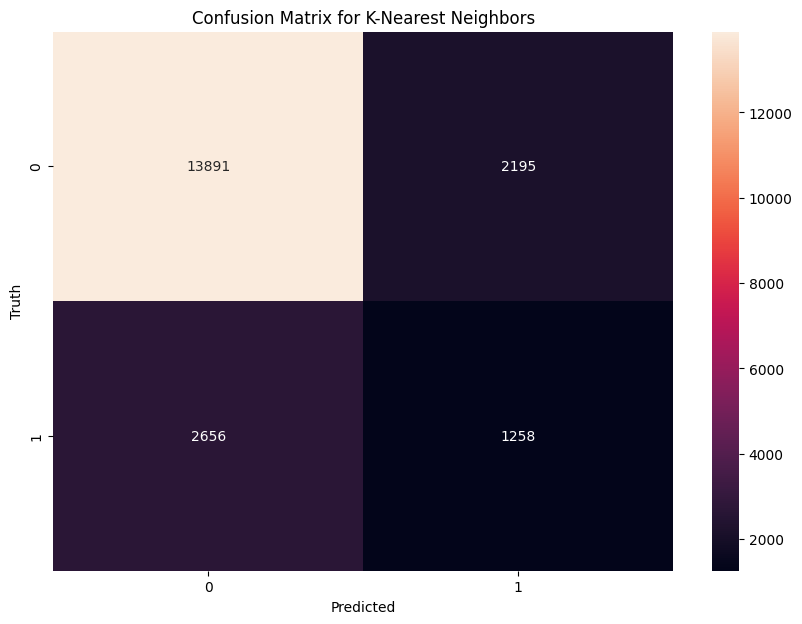

In [61]:
knn_cm_test = confusion_matrix(y_test, knn_predictions_test)
# Plotting confusion matrix for K-Nearest Neighbors
plt.figure(figsize=(10,7))
sns.heatmap(knn_cm_test, annot=True, fmt='d')
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

##### Random Forest

Cross Validation with Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

print("Cross-validation scores: ", scores)
print("Average cross-validation score: ", scores.mean())

Cross-validation scores:  [1. 1. 1. 1. 1.]
Average cross-validation score:  1.0


Random Forest predictions

In [63]:
# Define the model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest.fit(X_train_scaled, y_train)

# Make predictions on your validation data
rf_predictions_val = random_forest.predict(X_val_scaled)

# Evaluate your model
print("Random Forest performance on validation data:")
print(classification_report(y_val, rf_predictions_val))

# Make predictions on your test data
rf_predictions_test = random_forest.predict(X_test_scaled)

# Evaluate your model on test data
print("Random Forest performance on test data:")
print(classification_report(y_test, rf_predictions_test))

Random Forest performance on validation data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7320
           1       1.00      1.00      1.00       700

    accuracy                           1.00      8020
   macro avg       1.00      1.00      1.00      8020
weighted avg       1.00      1.00      1.00      8020

Random Forest performance on test data:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     16086
           1       1.00      0.81      0.90      3914

    accuracy                           0.96     20000
   macro avg       0.98      0.91      0.94     20000
weighted avg       0.96      0.96      0.96     20000



Random Forest confusion matrix with validation data.

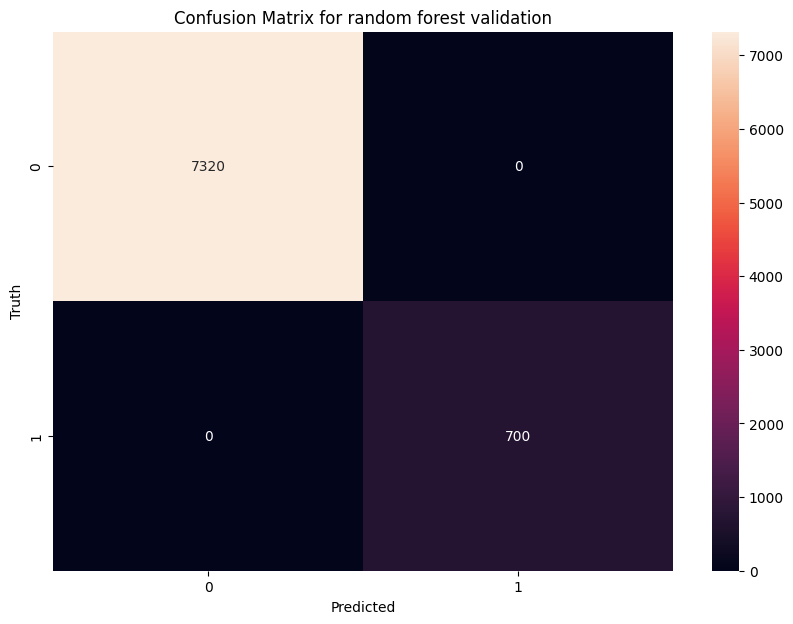

In [65]:
rf_cm_val = confusion_matrix(y_val, rf_predictions_val)
# Plotting confusion matrix for K-Nearest Neighbors
plt.figure(figsize=(10,7))
sns.heatmap(rf_cm_val, annot=True, fmt='d')
plt.title('Confusion Matrix for random forest validation')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Random Forest confusion matrix with test data.

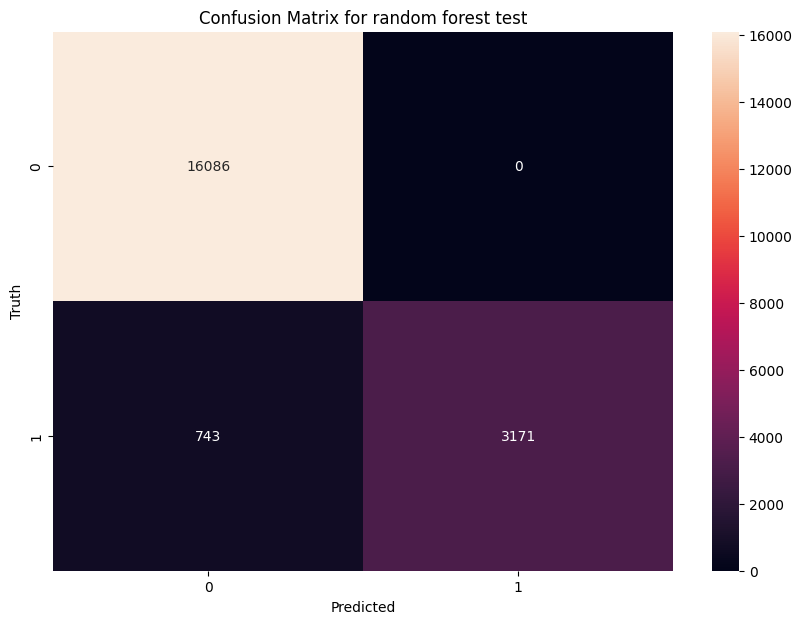

In [66]:
rf_cm_test = confusion_matrix(y_test, rf_predictions_test)
# Plotting confusion matrix for K-Nearest Neighbors
plt.figure(figsize=(10,7))
sns.heatmap(rf_cm_test, annot=True, fmt='d')
plt.title('Confusion Matrix for random forest test')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()